In [1]:
import numpy as np
import os
import pickle
import time
import matplotlib.pyplot as plt

# from utils import get_def_name, get_tags_from_first_tiff, get_tiff_list, timer_decorator
from utils import *
from multi_threading import read_all_images, parallel_exponentiate_RMS, parallel_sum

### Functions

RMS_image_array_csr.pkl 108MB

RMS_image_array.pkl 72MB

In [2]:
"""
Hello world
"""

# Mirror of sum_array_dense()
# Should create a dense sparse matrix output
@timer_decorator
def get_RMS_array_dense(tiff_path, **kwargs):
    debugging = kwargs.get('debugging', False)
    pickle_usage = kwargs.get('pickle_usage', True)
    
    image_arrays = read_all_images(tiff_path, **kwargs)
    if debugging==True and pickle_usage==False:
        print('NOT USING PICKLE')

    if os.path.exists(f'{tiff_path}\\RMS_image_array.pkl') and pickle_usage==True:
        with open(f'{tiff_path}\\RMS_image_array.pkl', 'rb') as f:
            # RMS_array_csr = pickle.load(f)
            RMS_array = pickle.load(f)
        print('Loaded RMS_image_array.pkl')

        # # if RMS_array is csr sparse, convert it to dense
        # if issparse(RMS_array):
        #     RMS_array = RMS_array.toarray()
        #     with open(f'{tiff_path}\\RMS_image_array.pkl', 'wb') as f:
        #         pickle.dump(RMS_array, f)
    
    else:

        squaring_start_time = time.time()
        # square = [img.power(2) for img in image_arrays]
        square = parallel_exponentiate_RMS(image_arrays, 2)

        squaring_end_time = time.time()
        if debugging==True:
            print(f'Squaring time: {squaring_end_time - squaring_start_time:.1f} seconds. With {get_def_name()}')


        adding_start_time = time.time()
        # RMS_array_csr = (reduce(add, square) / len(square)).power(0.5)
        RMS_array_csr = (parallel_sum(square) / len(square)).power(0.5)

        adding_end_time = time.time()
        if debugging==True:
            print(f'Adding time: {adding_end_time - adding_start_time:.1f} seconds. With {get_def_name()}')


        if debugging==True:
            # print(f'Total RMS_array elements: {RMS_array_csr.size}')    # 开什么玩笑，要吐了！应该直接取Image Dimension!
            _, image_width, image_length = get_tags_from_first_tiff(tiff_path)[:3]
            total_pixel_amount = image_width * image_length
            print(f'Total RMS_array elements: {total_pixel_amount}')
            print(f'Non-zero RMS_array elements: {RMS_array_csr.nnz}')
            print(f'Zero RMS_array elements: {total_pixel_amount - RMS_array_csr.nnz}')


        RMS_array = RMS_array_csr.toarray()
        if pickle_usage==True:
            with open(f'{tiff_path}\\RMS_image_array.pkl', 'wb') as f:
                pickle.dump(RMS_array, f)

            # with open(f'{tiff_path}\\RMS_image_array_csr.pkl', 'wb') as f:
            #     pickle.dump(RMS_array_csr, f)

    return RMS_array

def get_camera_RMS(RMS_array):
    """
    RMS_array is an array of pixel RMSs
    Calculating RMS of RMS_array is the same as calculating RMS for img_arrays
    """
    return np.sqrt(np.mean(RMS_array**2))


### plot RMS

In [3]:
@timer_decorator
def plot_RMS(RMS_array, tiff_path, **kwargs):
    plot_type = kwargs.get('plot_type', 'bar')
    debugging = kwargs.get('debugging', True)
    bin_amount = kwargs.get('bin_amount', 100)
    heatmap_max = kwargs.get('heatmap_max')
    save = kwargs.get('save', False)

    tiff_filenames = get_tiff_list(tiff_path)

    # RMS_array = RMS_array_csr.toarray()

    # caption_tags, image_width, image_length = get_tags_from_first_tiff(tiff_path)
    caption_tags, image_width, image_length, exposure_time_ms = get_tags_from_first_tiff(tiff_path)[:4]
    total_pixel_amount = image_width * image_length

    caption_statistics_RMS = f'{np.sum(RMS_array==0)} pixels had 0 count in the whole set of data, {np.sum(RMS_array==0) / total_pixel_amount * 100:.1f}%; \n' + \
            f'RMS(10% of the pixels) <= {np.percentile(RMS_array, 10):.3f}; \n' + \
            f'RMS(90% of the pixels) <= {np.percentile(RMS_array, 90):.3f}; \n' + \
            f'pixel max-RMS: {np.max(RMS_array):.3f} e- \n' + \
            f'Camera RMS: {get_camera_RMS(RMS_array):.3f} e-'
    figname_optional = ''


    if plot_type == 'bar':
        # It was cutting right tail of the histogram. Name a max for it
        # counts, bin_edges = np.histogram(RMS_array.flatten(), bins=bin_amount)
        min_value = 0
        max_value = np.max(RMS_array)
        counts, bin_edges = np.histogram(RMS_array.flatten(), bins=bin_amount, range=(min_value, max_value))

        if debugging==True:
            # print(f'bin amount: {bin_amount}')
            print(f'bins width: {np.average(np.diff(bin_edges))}')
            max_fraction_bin = np.max(counts) / np.sum(counts)
            print(f'{100*max_fraction_bin:.1f}% of pixel RMS errors fall between '
                f'{np.argmax(counts)} and {np.argmax(counts) + np.diff(bin_edges)[0]} counts in all {len(tiff_filenames)} frames')

        # counts_normalized = counts / counts.max()

        fig = plt.figure(figsize=(10, 6))
        # plt.bar(bin_edges[:-1], counts_normalized, width=np.diff(bin_edges), color='gray', log=True, align='edge')
        plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), color='gray', log=True, align='edge')

        plt.xlabel('RMS')
        plt.ylabel('Frequency')

        figname_optional += f'_{len(tiff_filenames)}frames'
        
        fig.text(0.15, 0.05, caption_tags + caption_statistics_RMS, ha='left')
        plt.subplots_adjust(bottom=0.3)

    elif plot_type == 'heat':
        heat_plot_width = np.round(image_width/image_length * 6, 1) + 2
        fig = plt.figure(figsize=(heat_plot_width, 6), dpi=400)
        
        plt.imshow(RMS_array, cmap='hot', interpolation='nearest', vmax=heatmap_max)
        plt.colorbar(label='RMS')
        if heatmap_max is not None:
            caption_tags += f'Clipped at {heatmap_max} counts\n'
            figname_optional += f'_clip{heatmap_max}'

        figname_optional += f'_{len(tiff_filenames)}frames'

        fig.text(0.15, 0.05, caption_tags + caption_statistics_RMS, ha='left')
        plt.subplots_adjust(bottom=0.25)


    if save==True:
        plt.savefig(f'RMS_{plot_type}{figname_optional}_{exposure_time_ms}ms_{image_width}x{image_length}.png')
    plt.show()

### Testing

NOT USING PICKLE

File reading time: 784.8 seconds. With DEF read_all_images_RMS()


##### Square multi-processed \\full_1s_6000_shot

Squaring time: 60.8 seconds. With DEF get_RMS_array_dense()

Adding time: 179.4 seconds. With DEF get_RMS_array_dense()

##### Square & Adding \\full_1s_6000_shot

Squaring time: 71.9 seconds. With DEF get_RMS_array_dense()

Adding time: 124.0 seconds. With DEF get_RMS_array_dense()

C:\LABDATA_office\3.12 qCMOS\full_200ms_6000shots_cutfrom6247
Loaded image_arrays.pkl
Function read_all_images took 5.6 seconds to run.
Loaded RMS_image_array.pkl
Function get_RMS_array_dense took 6.3 seconds to run.
bins width: 0.033016662460036754
21.3% of pixel RMS errors fall between 1 and 1.0330166624600368 counts in all 6000 frames


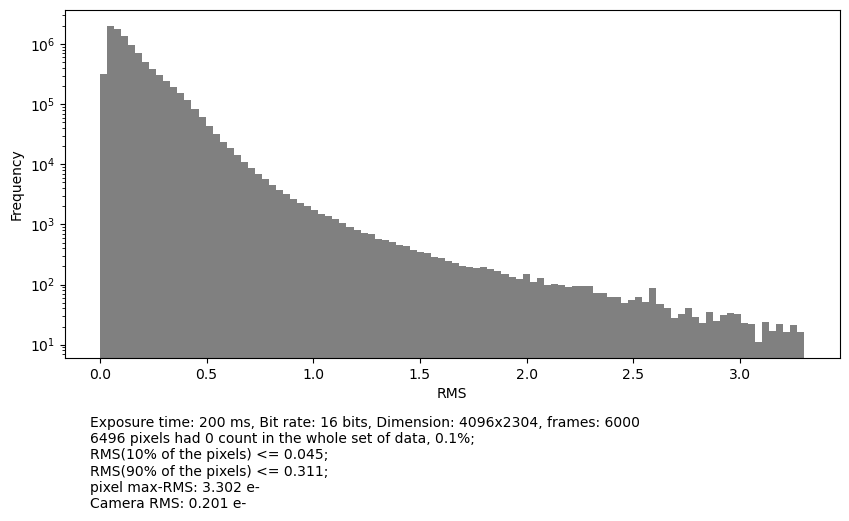

Function plot_RMS took 1.3 seconds to run.


In [4]:
tiff_main_folder = 'C:\\LABDATA_office\\3.12 qCMOS'
# tiff_path = tiff_main_folder + '\\full_1s_6000_shot'
# tiff_path = tiff_main_folder + '\\full_frame_quick'
# tiff_path = tiff_main_folder + '\\full_frame'
# tiff_path = tiff_main_folder + '\\full_200ms_6247shots'
tiff_path = tiff_main_folder + '\\full_200ms_6000shots_cutfrom6247'
# tiff_path = tiff_main_folder + '\\full_5s_2000shots'
# tiff_path = tiff_main_folder + '\\full_5s_6000shots'


RMS_array = get_RMS_array_dense(tiff_path, tiff_amount_cutoff=6000, debugging=True)
# print('Max element:', RMS_array.max())
# print('Min element:', RMS_array.min())
# print('Min non-zero element:', RMS_array[RMS_array > 0].min())

# print(f'issparse(RMS_array)? {issparse(RMS_array)}')
# plot_RMS(RMS_array, tiff_path, plot_type='heat', save=True)
plot_RMS(RMS_array, tiff_path, plot_type='bar', save=True)

In [5]:
# tiff_path = tiff_main_folder + '\\full_200ms_6000shots_cutfrom6247'
# RMS_array_200ms = get_RMS_array_dense(tiff_path, tiff_amount_cutoff=6000, debugging=True)
# cameraRMS_200ms = get_camera_RMS(RMS_array_200ms)

# tiff_path = tiff_main_folder + '\\full_5s_6000shots'
# RMS_array_5000ms = get_RMS_array_dense(tiff_path, tiff_amount_cutoff=6000, debugging=True)
# cameraRMS_5000ms = get_camera_RMS(RMS_array_5000ms)

In [6]:
# # print(f'cameraRMS_200ms:{cameraRMS_200ms} e-')
# # print(f'cameraRMS_5000ms:{cameraRMS_5000ms} e-')
# dark_current = (cameraRMS_5000ms - cameraRMS_200ms) / 4.8
# print(f'Dark current:{dark_current} e-/(pixel*s)')